In [1]:
import gymnasium as gym
import os
import source.config as config
from source.algorithms import *
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import source.farm_env # Import necessary to register the gym environment

In [2]:
env = gym.make(id='FarmEnv-v0',
                initial_budget = config.INITIAL_BUDGET,
                sheep_cost = config.SHEEP_COST,
                wheat_cost = config.WHEAT_COST,
                wool_price = config.WOOL_PRICE,
                wheat_price = config.WHEAT_PRICE,
                max_years = config.MAX_YEARS,
                wool_fixed_cost = config.WOOL_FIXED_COST,
                storm_probability = config.STORM_PROBABILITY,
                incest_penalty = config.INCEST_PENALTY,
                reward_std = config.SIGMA
                )

In [3]:
def conv(a, win=100):
    return np.convolve(a, np.ones(win), mode='same') / win

In [4]:
learning_rate = 0.001
policy_learning_rate = 1e-4
value_learning_rate = 1e-4
n_episodes = 500_000
start_epsilon = 1.0
epsilon_decay = start_epsilon / (n_episodes)  # reduce the exploration over time
final_epsilon = 0.1

REINFORCE_agent = FarmAgentNeuralREINFORCEAdvantage(
    environment=env, policy_learning_rate=policy_learning_rate, value_learning_rate=value_learning_rate, epsilon=start_epsilon, epsilon_decay=epsilon_decay, final_epsilon=final_epsilon, gamma=.999,
    # policy_net_weights_path='agent_models/policy_net_weights.pth', value_net_weights_path='agent_models/value_net_weights.pth'
)

MC_vfa_agent = FarmAgentMCVFA(
    environment=env, learning_rate=learning_rate, epsilon=start_epsilon, epsilon_decay=epsilon_decay, final_epsilon=final_epsilon, gamma=.999
)

SARSA_vfa_agent = FarmAgentSarsaVFA(
    environment=env, learning_rate=learning_rate, epsilon=start_epsilon, epsilon_decay=epsilon_decay, final_epsilon=final_epsilon, gamma=.95
)

c:\Users\leoac\AppData\Local\pypoetry\Cache\virtualenvs\manage-a-farm-jQWtjN-A-py3.11\Lib\site-packages\gymnasium\utils\passive_env_checker.py:131: UserWarning: WARN: The obs returned by the `reset()` method was expecting a numpy array, actual type: <class 'int'>
  logger.warn(
c:\Users\leoac\AppData\Local\pypoetry\Cache\virtualenvs\manage-a-farm-jQWtjN-A-py3.11\Lib\site-packages\gymnasium\spaces\box.py:240: UserWarning: WARN: Casting input x to numpy array.
  gym.logger.warn("Casting input x to numpy array.")
c:\Users\leoac\AppData\Local\pypoetry\Cache\virtualenvs\manage-a-farm-jQWtjN-A-py3.11\Lib\site-packages\gymnasium\utils\passive_env_checker.py:159: UserWarning: WARN: The obs returned by the `reset()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")


# REINFORCE

In [5]:
nenv = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)
final_budget_queue = []

for episode in tqdm(range(n_episodes)):
    REINFORCE_agent.update(episode_number=episode)
    REINFORCE_agent.decay_epsilon()
    final_budget_queue.append(nenv.unwrapped.budget)

    # Optionally, you can print some statistics every N episodes
    if episode % 10000 == 0:
        avg_budget = sum(final_budget_queue[-10000:]) / min(10000, len(final_budget_queue))
        print(f"Episode {episode}, Average Budget: {avg_budget:.2f}") #, Weights: {list(REINFORCE_agent.policy_net.parameters())}")

  0%|          | 0/500000 [00:00<?, ?it/s]c:\Users\leoac\AppData\Local\pypoetry\Cache\virtualenvs\manage-a-farm-jQWtjN-A-py3.11\Lib\site-packages\gymnasium\utils\passive_env_checker.py:131: UserWarning: WARN: The obs returned by the `step()` method was expecting a numpy array, actual type: <class 'float'>
  logger.warn(
c:\Users\leoac\AppData\Local\pypoetry\Cache\virtualenvs\manage-a-farm-jQWtjN-A-py3.11\Lib\site-packages\gymnasium\spaces\box.py:240: UserWarning: WARN: Casting input x to numpy array.
  gym.logger.warn("Casting input x to numpy array.")
c:\Users\leoac\AppData\Local\pypoetry\Cache\virtualenvs\manage-a-farm-jQWtjN-A-py3.11\Lib\site-packages\gymnasium\utils\passive_env_checker.py:159: UserWarning: WARN: The obs returned by the `step()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")
c:\Users\leoac\AppData\Local\pypoetry\Cache\virtualenvs\manage-a-farm-jQWtjN-A-py3.11\Lib\site-packages\gymnasium\utils\passive_env_chec

Episode 0, Average Budget: 1.51


  2%|▏         | 10013/500000 [01:04<1:03:54, 127.80it/s]

Episode 10000, Average Budget: 1.58


  4%|▍         | 20031/500000 [02:03<45:44, 174.87it/s]  

Episode 20000, Average Budget: 1.58


  6%|▌         | 30021/500000 [03:02<53:10, 147.32it/s]  

Episode 30000, Average Budget: 1.59


  8%|▊         | 40029/500000 [04:03<45:40, 167.82it/s]  

Episode 40000, Average Budget: 1.62


 10%|█         | 50029/500000 [05:06<41:28, 180.81it/s]  

Episode 50000, Average Budget: 1.64


 12%|█▏        | 60007/500000 [07:17<2:02:56, 59.64it/s]  

Episode 60000, Average Budget: 1.67


 14%|█▍        | 70010/500000 [10:13<1:59:23, 60.02it/s]

Episode 70000, Average Budget: 1.66


 16%|█▌        | 80008/500000 [13:12<2:00:36, 58.04it/s]

Episode 80000, Average Budget: 1.70


 18%|█▊        | 90006/500000 [16:15<2:01:25, 56.27it/s]

Episode 90000, Average Budget: 1.71


 20%|██        | 100006/500000 [19:59<2:02:03, 54.62it/s]

Episode 100000, Average Budget: 1.71


 22%|██▏       | 110005/500000 [23:19<5:07:46, 21.12it/s]

Episode 110000, Average Budget: 1.72


 24%|██▍       | 120009/500000 [26:00<1:41:36, 62.33it/s]

Episode 120000, Average Budget: 1.79


 26%|██▌       | 130010/500000 [28:38<1:51:26, 55.34it/s]

Episode 130000, Average Budget: 1.75


 28%|██▊       | 140011/500000 [30:33<57:26, 104.44it/s]  

Episode 140000, Average Budget: 1.80


 30%|███       | 150016/500000 [32:24<1:01:54, 94.23it/s]

Episode 150000, Average Budget: 1.82


 32%|███▏      | 160010/500000 [34:10<1:02:29, 90.67it/s]

Episode 160000, Average Budget: 1.84


 34%|███▍      | 170021/500000 [35:58<55:23, 99.28it/s]  

Episode 170000, Average Budget: 1.86


 36%|███▌      | 180020/500000 [37:46<50:50, 104.89it/s] 

Episode 180000, Average Budget: 1.90


 38%|███▊      | 190026/500000 [39:13<36:02, 143.34it/s] 

Episode 190000, Average Budget: 1.91


 40%|████      | 200029/500000 [40:25<36:24, 137.33it/s]

Episode 200000, Average Budget: 1.95


 42%|████▏     | 210015/500000 [41:40<32:43, 147.72it/s] 

Episode 210000, Average Budget: 1.96


 44%|████▍     | 220023/500000 [42:51<31:39, 147.40it/s]

Episode 220000, Average Budget: 1.94


 46%|████▌     | 230020/500000 [44:05<32:25, 138.80it/s]

Episode 230000, Average Budget: 2.02


 48%|████▊     | 240022/500000 [45:19<32:55, 131.62it/s]

Episode 240000, Average Budget: 2.09


 50%|█████     | 250017/500000 [46:33<30:27, 136.78it/s]

Episode 250000, Average Budget: 2.08


 52%|█████▏    | 260014/500000 [47:49<28:42, 139.34it/s]

Episode 260000, Average Budget: 2.09


 54%|█████▍    | 270024/500000 [49:08<29:34, 129.61it/s]

Episode 270000, Average Budget: 2.05


 56%|█████▌    | 280027/500000 [50:26<31:05, 117.90it/s]

Episode 280000, Average Budget: 2.13


 58%|█████▊    | 290024/500000 [51:53<23:29, 148.97it/s] 

Episode 290000, Average Budget: 2.19


 60%|██████    | 300022/500000 [53:00<20:44, 160.65it/s]

Episode 300000, Average Budget: 2.24


 62%|██████▏   | 310025/500000 [54:10<22:12, 142.56it/s]

Episode 310000, Average Budget: 2.33


 64%|██████▍   | 320023/500000 [55:22<22:47, 131.63it/s]

Episode 320000, Average Budget: 2.36


 66%|██████▌   | 330016/500000 [56:38<22:06, 128.19it/s]

Episode 330000, Average Budget: 2.41


 68%|██████▊   | 340023/500000 [57:56<21:08, 126.15it/s]

Episode 340000, Average Budget: 2.47


 70%|███████   | 350014/500000 [59:20<22:57, 108.90it/s]

Episode 350000, Average Budget: 2.54


 72%|███████▏  | 360018/500000 [1:00:44<19:10, 121.62it/s]

Episode 360000, Average Budget: 2.61


 74%|███████▍  | 370019/500000 [1:02:09<18:24, 117.64it/s]

Episode 370000, Average Budget: 2.64


 76%|███████▌  | 380011/500000 [1:03:34<16:43, 119.55it/s]

Episode 380000, Average Budget: 2.71


 78%|███████▊  | 390022/500000 [1:04:59<14:30, 126.35it/s]

Episode 390000, Average Budget: 2.78


 80%|████████  | 400021/500000 [1:06:25<15:09, 109.96it/s]

Episode 400000, Average Budget: 2.82


 82%|████████▏ | 410020/500000 [1:07:58<14:59, 100.05it/s]

Episode 410000, Average Budget: 2.86


 84%|████████▍ | 420009/500000 [1:09:36<12:59, 102.56it/s]

Episode 420000, Average Budget: 2.95


 86%|████████▌ | 430012/500000 [1:11:16<10:33, 110.50it/s]

Episode 430000, Average Budget: 3.02


 88%|████████▊ | 440018/500000 [1:12:45<08:25, 118.65it/s]

Episode 440000, Average Budget: 3.08


 90%|█████████ | 450016/500000 [1:14:13<07:15, 114.69it/s]

Episode 450000, Average Budget: 3.15


 92%|█████████▏| 460013/500000 [1:15:42<05:55, 112.64it/s]

Episode 460000, Average Budget: 3.19


 94%|█████████▍| 470012/500000 [1:17:13<04:11, 119.02it/s]

Episode 470000, Average Budget: 3.22


 96%|█████████▌| 480019/500000 [1:18:55<03:05, 107.74it/s]

Episode 480000, Average Budget: 3.26


 98%|█████████▊| 490015/500000 [1:20:38<01:34, 105.67it/s]

Episode 490000, Average Budget: 3.26


100%|██████████| 500000/500000 [1:22:12<00:00, 101.36it/s]


Statistics evaluation

In [6]:
w = 1000
# rewards = conv(np.array(nenv.return_queue).flatten(), win=w)
# lengths = conv(np.array(nenv.length_queue).flatten(), win=w)
# error = conv(np.array(REINFORCE_agent.training_error).flatten(), win=w)
final_budgets = conv(np.array(final_budget_queue), win=w)

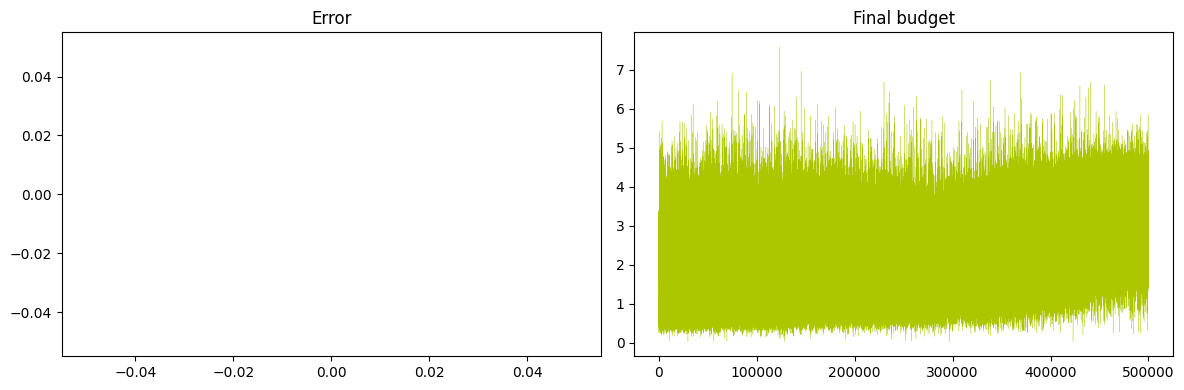

In [7]:
fig, ax = plt.subplots(figsize=(12, 4), ncols=2)
sns.lineplot(x=range(len(np.array(0).flatten())), y=np.array(0).flatten(), ax=ax[0], c='#acc700', linewidth=.2)
ax[0].set_title('Error')
sns.lineplot(x=range(len(final_budget_queue)), y=final_budget_queue, ax=ax[1], c='#acc700', linewidth=.2)
ax[1].set_title('Final budget')
plt.tight_layout()
plt.show()

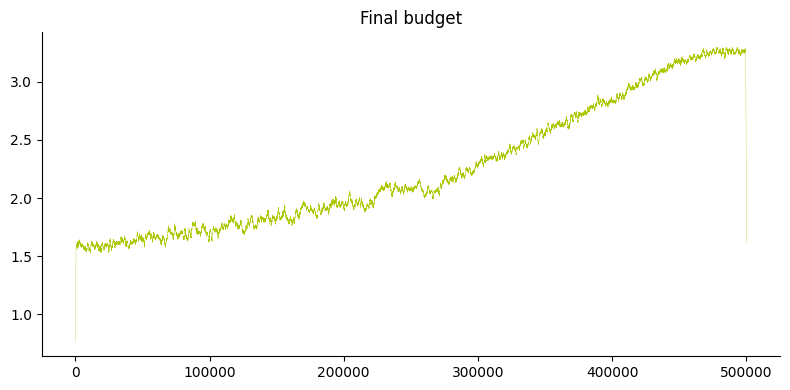

In [48]:
fig, ax = plt.subplots(figsize=(8, 4))
sns.lineplot(x=range(len(final_budgets)), y=final_budgets, ax=ax, c='#acc700', linewidth=.2)
ax.set_title('Final budget')

# Remove spines on top and right sides
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

In [78]:
state, info = env.reset()
for _ in range(30):
    options = env.unwrapped.actions_available
    action = REINFORCE_agent.policy(state, greedy=True)
    
    s_prime, reward, terminated, truncated, info = env.step(action)
    print(f'Action: {action}', f'State: {state}', f'Reward: {round(reward,3)}', f'Terminated: {terminated}', truncated, info)

    if terminated or truncated:
        print(f'Final state: {s_prime}')
        print("============End of episode============")
        state, info = env.reset()
        break
    else:
        state = s_prime
env.close()

Action: 0 State: {'budget': 2, 'sheep_count': 0, 'bought_sheep_count': 0, 'sheep_reproduction_probability': 0.00316227766016838, 'year': 0} Reward: -0.0 Terminated: False False {}
Action: 0 State: {'budget': 1.001, 'sheep_count': 1, 'bought_sheep_count': 1, 'sheep_reproduction_probability': 0.00316227766016838, 'year': 1} Reward: -0.0 Terminated: False False {}
Action: 2 State: {'budget': 0.011999999999999891, 'sheep_count': 3, 'bought_sheep_count': 2, 'sheep_reproduction_probability': 1.0, 'year': 2} Reward: 0.0 Terminated: False False {}
Action: 1 State: {'budget': 0.03299999999999989, 'sheep_count': 3, 'bought_sheep_count': 2, 'sheep_reproduction_probability': 0.3628873693012115, 'year': 3} Reward: 0.0 Terminated: False False {}
Action: 1 State: {'budget': 0.0839999999999999, 'sheep_count': 4, 'bought_sheep_count': 2, 'sheep_reproduction_probability': 0.3628873693012115, 'year': 4} Reward: 0.0 Terminated: False False {}
Action: 1 State: {'budget': 0.09499999999999989, 'sheep_count':

Save model

In [83]:
experiment_folder = 's6-penalty2.5-edecay1-g0.999'
os.makedirs(f'agent_models/REINFORCENeuralAdvantage/{experiment_folder}', exist_ok=True)
torch.save(REINFORCE_agent.policy_net.state_dict(), f'agent_models/REINFORCENeuralAdvantage/{experiment_folder}/policy_net_weights-{int(n_episodes/1000)}k.pth')
torch.save(REINFORCE_agent.value_net.state_dict(), f'agent_models/REINFORCENeuralAdvantage/{experiment_folder}/value_net_weights-{int(n_episodes/1000)}k.pth')

Save data

In [84]:
os.makedirs(f'data/REINFORCENeuralAdvantage/{experiment_folder}', exist_ok=True)
np.save(f'data/REINFORCENeuralAdvantage/{experiment_folder}/final_budget_queue-{int(n_episodes/1000)}k.npy', np.array(final_budget_queue))

# Montecarlo VFA

In [ ]:
nenv = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)
final_budget_queue = []
for episode in tqdm(range(n_episodes)):
    MC_vfa_agent.update(episode_number=episode)
    MC_vfa_agent.decay_epsilon()
    final_budget_queue.append(nenv.unwrapped.budget)

Statistics evaluation

In [ ]:
w = 1000
# rewards = conv(np.array(nenv.return_queue).flatten(), win=w)
# lengths = conv(np.array(nenv.length_queue).flatten(), win=w)
error = conv(np.array(MC_vfa_agent.training_error).flatten(), win=w)
final_budgets = conv(np.array(final_budget_queue), win=w)

In [ ]:
len(error), len(final_budgets)

In [ ]:
fig, ax = plt.subplots(figsize=(12, 4), ncols=2)
sns.lineplot(x=range(len(np.array(MC_vfa_agent.training_error).flatten())), y=np.array(MC_vfa_agent.training_error).flatten(), ax=ax[0], c='#acc700', linewidth=.2)
ax[0].set_title('Error')
sns.lineplot(x=range(len(final_budget_queue)), y=final_budget_queue, ax=ax[1], c='#acc700', linewidth=.2)
ax[1].set_title('Final budget')
plt.tight_layout()
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(12, 4), ncols=2)
sns.lineplot(x=range(len(error)), y=error, ax=ax[0], c='#acc700', linewidth=.2)
ax[0].set_title('Error')
sns.lineplot(x=range(len(final_budgets)), y=final_budgets, ax=ax[1], c='#acc700', linewidth=.2)
ax[1].set_title('Final budget')
plt.tight_layout()
plt.show()

In [ ]:
MC_vfa_agent.w

In [ ]:
state, info = env.reset()
for _ in range(30):
    options = env.unwrapped.actions_available
    action = MC_vfa_agent.greedy_policy(state)
    
    s_prime, reward, terminated, truncated, info = env.step(action)
    print(f'Action: {action}', f'State: {state}', f'Reward: {round(reward,3)}', f'Terminated: {terminated}', truncated, info)

    if terminated or truncated:
        print(f'Final state: {s_prime}')
        print("============End of episode============")
        state, info = env.reset()
        break
    else:
        state = s_prime
env.close()

In [ ]:
experiment_folder = 'gaussian_delta-nowoolcost-15woolprice-200k'
os.makedirs(f'data/MCVFA/{experiment_folder}', exist_ok=True)

np.save(f'data/MCVFA/{experiment_folder}/weights.npy', MC_vfa_agent.w.detach().numpy())
np.save(f'data/MCVFA/{experiment_folder}/final_budget_queue.npy', np.array(final_budget_queue))
np.save(f'data/MCVFA/{experiment_folder}/training_error.npy', np.array(MC_vfa_agent.training_error).flatten())
# Split the 15M training error records in two chunks not to exceed GitHub limit of 100MB per file
# np.save('data/MCVFA/training_error_0k-750k.npy', MC_vfa_agent.training_error[: len(MC_vfa_agent.training_error) // 2])
# np.save('data/MCVFA/training_error_750k-1.5M.npy', MC_vfa_agent.training_error[len(MC_vfa_agent.training_error) // 2 : ])

# SARSA VFA

In [ ]:
nenv = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)
final_budget_queue = []
for episode in tqdm(range(n_episodes)):
    state, info = nenv.reset()
    done = False
    while not done:
        action = SARSA_vfa_agent.policy(state)
        # print(action)
        s_prime, reward, terminated, truncated, info = nenv.step(action=action)
        # update
        SARSA_vfa_agent.update(state, action, reward, s_prime)
        done = terminated or truncated
        state = s_prime
    SARSA_vfa_agent.decay_epsilon()
    final_budget_queue.append(nenv.unwrapped.budget)

Statistics evaluation

In [ ]:
w = 100
rewards = conv(np.array(nenv.return_queue).flatten(), win=w)
lengths = conv(np.array(nenv.length_queue).flatten(), win=w)
error = conv(np.array(SARSA_vfa_agent.training_error).flatten(), win=w)
final_budgets = conv(np.array(final_budget_queue), win=w)

In [ ]:
len(rewards),len(lengths),len(SARSA_vfa_agent.training_error)

In [ ]:
fig, ax = plt.subplots(figsize=(16, 4), ncols=4)
ax[0].plot(range(len(nenv.return_queue)), nenv.return_queue, c='#acc700', linewidth=.4)
ax[0].set_title('Reward (Average)')
ax[1].plot(range(len(nenv.length_queue)), nenv.length_queue, c='#acc700', linewidth=.8)
ax[1].set_title('Episode Length')
ax[2].plot(range(len(SARSA_vfa_agent.training_error)), SARSA_vfa_agent.training_error, c='#acc700', linewidth=.2)
ax[2].set_title('Error')
ax[3].plot(range(len(final_budget_queue)), final_budget_queue, c='#acc700', linewidth=.2)
ax[3].set_title('Final budget')
plt.tight_layout()
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(16, 4), ncols=4)
sns.lineplot(x=range(len(rewards)), y=rewards, ax=ax[0], c='#acc700', linewidth=.4)
ax[0].set_title('Reward (Average)')
sns.lineplot(x=range(len(lengths)), y=lengths, ax=ax[1], c='#acc700', linewidth=.4)
ax[1].set_title('Episode Length')
sns.lineplot(x=range(len(error)), y=error, ax=ax[2], c='#acc700', linewidth=.2)
ax[2].set_title('Error')
sns.lineplot(x=range(len(final_budgets)), y=final_budgets, ax=ax[3], c='#acc700', linewidth=.2)
ax[3].set_title('Final budget')
plt.tight_layout()
plt.show()

In [ ]:
SARSA_vfa_agent.w